In [1]:
import pandas as pd
import codecs

In [2]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import urllib
import urllib.request as uReq
site = "http://www.imdb.com/chart/tvmeter"
uClient = uReq.urlopen(site)
page_html = uClient.read()
uClient.close()

import bs4                           
from bs4 import BeautifulSoup 

import pickle                                 # important to save data 

soup = BeautifulSoup(page_html,"html.parser")

containers = soup.findAll("tbody",{"class":"lister-list"})
print(len(containers))    #1

print(type(containers[0]))

rows = containers[0].findAll("tr")

dataSet = {
	'Name_Of_Show':[],
	'Year_Of_Release':[],
	'Ranking_Change_Jump':[],
	'Users_count':[],
	'Rating':[]

}

# for saving the data
file = open("TV_Shows.csv","w+")

# Columns of the dataset
file.write('Name_Of_Show'+','+'Year_Of_Release'+','+'Ranking_Change_Jump'+','+'Users_count'+','+'Rating'+'\n')


# Iterating over column and saving results to the dataset
for i in range(len(rows)):
	
    
    # Add Names of the show to the dataset Dictionary
	dataSet['Name_Of_Show'].append(rows[i].find("td",{"class":"titleColumn"}).find("a").text.replace(',', ' '))


    # Add Release Year of the shows to the dataset Dictionary
	dataSet['Year_Of_Release'].append(int(rows[i].find("td",{"class":"titleColumn"}).find("span").text.split('(')[1].split(')')[0]))
	
     # Adding jump in change of popularity
	if (rows[i].find("td",{"class":"titleColumn"}).find("div").text.encode('cp1252').decode('utf-8').split('(')[1].split(')')[0] == 'no change'):
		dataSet['Ranking_Change_Jump'].append('0')
	else:
		dataSet['Ranking_Change_Jump'].append(rows[i].find("td",{"class":"titleColumn"}).find("div").text.split('(')[1].split(')')[0].split('\n')[2].replace(',',''))
	

    # Adds totalno of users_count 
	try :
		dataSet['Users_count'].append(str(int(rows[i].find("td",{"class":["ratingColumn","imdbRating"]}).find("strong")['title'].split()[3].replace(',',''))))
	except TypeError:
		dataSet['Users_count'].append("")
	
    
    
    #Adds Rating of the TV Shows
	dataSet['Rating'].append(rows[i].find("td",{"class":["ratingColumn","imdbRating"]}).text.split('\n')[1])


    # Write  All Scrapped details to the dataset
	file.write(str(dataSet['Name_Of_Show'][i])+","+str(dataSet['Year_Of_Release'][i])+","+str(dataSet['Ranking_Change_Jump'][i])+","+str(dataSet['Users_count'][i])+","+str(dataSet['Rating'][i])+"\n")

file.close()	
#print(dataSet)

1
<class 'bs4.element.Tag'>


In [3]:
pd.read_csv('TV_Shows.csv', index_col=0  , encoding='ISO-8859-1')

,Year_Of_Release,Ranking_Change_Jump,Users_count,Rating
Name_Of_Show,,,,
The Lincoln Lawyer,2022,33,12042.0,7.7
Better Call Saul,2015,0,413340.0,8.8
She-Hulk: Attorney at Law,2022,416,NaN,NaN
Candy,2022,0,5100.0,7.3
The Staircase,2022,4,5485.0,7.4
...,...,...,...,...
The Wire,2002,6,326209.0,9.3
Fear the Walking Dead,2015,4,127042.0,6.8
Suits,2011,14,396609.0,8.5


In [39]:
import pandas as pd
# Charger des données
df_products=pd.read_csv(r"C:\Users\ak.benhassine\TV_Shows.csv", index_col=0, encoding='ISO-8859-1')
# Remplacer date de recrutement par annee de recrutement
from datetime import datetime

def transform_annee_date(date):
    #date = datetime.strptime(date, '%d-%m-%y')
    annee_now=datetime.now().year
    #print(annee_now)
    #annee="01-01-"+str(date)
    #return annee_now-date
    return date

df_products['Users_count'] = df_products['Users_count'].replace(np.nan, 0)
df_products['Rating'] = df_products['Rating'].replace(np.nan, 0)
df_products['Year_Of_Release']=df_products.Year_Of_Release.apply(transform_annee_date)

def label_popularity (row):
    if (row['Rating'] < 7.3):
        return  "not popular"
    elif (7.3 <row['Rating']<7.5):
         return  "popular"
    else:
         return  "very popular"

df_products["popularity"] =df_products.apply (lambda row: label_popularity(row), axis=1)
df_products.head()

,Year_Of_Release,Ranking_Change_Jump,Users_count,Rating,popularity
Name_Of_Show,,,,,
The Lincoln Lawyer,2022,33,12042.0,7.7,very popular
Better Call Saul,2015,0,413340.0,8.8,very popular
She-Hulk: Attorney at Law,2022,416,0.0,0.0,not popular
Candy,2022,0,5100.0,7.3,very popular
The Staircase,2022,4,5485.0,7.4,popular


In [47]:
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
def calculer_score(client):
    return client['Users_count']/(client['Ranking_Change_Jump']+1)

class TransformationTVShows :
    def __init__(self, calcul_score=False):
        self.calcul_score=calcul_score
    def fit(self, df_products, y=None):
        X_=df_products.copy()
        self.ohe=OneHotEncoder()
        self.ohe.fit(X_.loc[:,['popularity']])
        return self
    def transform(self, X, y=None):
        X_=X.copy()
        
        # transformer niveau d'etudes selon OHE
        popularity_encoded=self.ohe.transform(X_.loc[:,['popularity']])
        df_popularity_encoded=pd.DataFrame(popularity_encoded.toarray(), 
                                                 columns='niveau_'+self.ohe.categories_[0],
                                                 index=X_.index)
        X_=pd.concat([X_,df_popularity_encoded], axis=1)
        X_.drop('popularity', axis=1, errors='ignore', inplace=True)

        if self.calcul_score==True:
            X_['score']=X_.apply(calculer_score, axis=1)
        return X_

In [50]:
trsf=TransformationTVShows(calcul_score=True)
trsf.fit(df_products)
X_trsf=trsf.transform(df_products)
X_trsf

,Year_Of_Release,Ranking_Change_Jump,Users_count,Rating,niveau_not popular,niveau_popular,niveau_very popular,score
Name_Of_Show,,,,,,,,
The Lincoln Lawyer,2022,33,12042.0,7.7,0.0,0.0,1.0,354.176471
Better Call Saul,2015,0,413340.0,8.8,0.0,0.0,1.0,413340.000000
She-Hulk: Attorney at Law,2022,416,0.0,0.0,1.0,0.0,0.0,0.000000
Candy,2022,0,5100.0,7.3,0.0,0.0,1.0,5100.000000
The Staircase,2022,4,5485.0,7.4,0.0,1.0,0.0,1097.000000
...,...,...,...,...,...,...,...,...
The Wire,2002,6,326209.0,9.3,0.0,0.0,1.0,46601.285714
Fear the Walking Dead,2015,4,127042.0,6.8,1.0,0.0,0.0,25408.400000
Suits,2011,14,396609.0,8.5,0.0,0.0,1.0,26440.600000


In [51]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
ss.fit(X_trsf)
df_products_ss=ss.transform(X_trsf)

In [17]:
df_products_ss

array([[ 8.03257630e-01, -7.38453478e-02, -5.82834490e-01,
        -3.94294765e-02],
       [-1.18513421e-01, -3.81534297e-01,  6.69501905e-01,
         6.49021700e-01],
       [ 8.03257630e-01,  3.49721125e+00, -6.20414131e-01,
        -4.85858771e+00],
       [ 8.03257630e-01, -3.81534297e-01, -6.04498488e-01,
        -2.89775359e-01],
       [ 8.03257630e-01, -3.44238667e-01, -6.03297013e-01,
        -2.27188888e-01],
       [ 1.44849736e-01, -3.53562574e-01,  2.73963854e-01,
         4.61262289e-01],
       [ 1.31681579e-02, -2.69647406e-01,  2.49273865e+00,
         5.86435230e-01],
       [ 8.03257630e-01, -3.62886482e-01, -4.89035181e-01,
        -4.77534771e-01],
       [ 1.31681579e-02, -3.25590852e-01, -1.97763314e-01,
         5.86435230e-01],
       [ 4.08212894e-01, -9.24931629e-02, -1.75905832e-01,
         3.98675818e-01],
       [ 8.03257630e-01, -3.25590852e-01, -1.37886170e-01,
        -1.64602418e-01],
       [ 8.03257630e-01, -3.34914759e-01, -5.92702188e-01,
      

In [52]:
from sklearn.decomposition import PCA
import numpy as np
df_products.replace([np.inf, -np.inf], np.nan, inplace=True)
pca=PCA(n_components=2)
pca.fit(df_products_ss)
df_products_pca=pca.transform(df_products_ss)

In [54]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2)
km.fit(df_products_pca)

KMeans(n_clusters=2)

In [55]:
labels=km.predict(df_products_pca)
labels

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [57]:
# NOus allons utiliser la techniques de classification SVM
# SVM : Support Vector Machine
# L'idée
from sklearn.svm import SVC
svm=SVC(kernel='linear')
svm.fit(df_products_pca,labels)

SVC(kernel='linear')

Text(0.5, 1.0, 'Clustering des Funs')

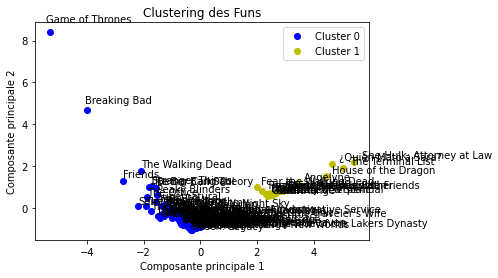

In [62]:
import matplotlib.pyplot as plt
plt.plot(df_products_pca[labels==0,0],df_products_pca[labels==0,1],'bo', label='Cluster 0')
plt.plot(df_products_pca[labels==1,0],df_products_pca[labels==1,1],'yo', label='Cluster 1')

plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')

for nom,x,y in zip(df_products.index,df_products_pca[:,0],df_products_pca[:,1]):
        plt.annotate(nom,
            xy=(x, y), 
            xycoords='data',
            xytext=(x+2, y+2), 
            textcoords='offset points')
plt.legend()
plt.title("Clustering des Funs")